### Some useful functions in the begining, just skip them. Results are right after

In [108]:
%matplotlib inline
import pandas as pd
import numpy as np
import distribution_generator as dg
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from  scipy.optimize import fsolve

import data_processing_utils as utils


from random import lognormvariate, normalvariate

from sklearn.neighbors import KernelDensity

import imports
import os
import json

from IPython.display import Audio
sound_file = './call.wav'
ALLERT = Audio(url=sound_file, autoplay=True)

In [2]:
def plotDensity(densities, log_flag = False, height = 4, width = 12, left = None, right = None, axes_limits = None,
               colors = None, name = None):
    
    if type(densities[0]) != list and type(densities[0]) != np.ndarray:
        densities = [densities]
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(1,1,1)

    if axes_limits:
        ax.axis(axes_limits)
        ax = plt.gca()
        ax.set_autoscale_on(False)

    if left is None:
        left = 0
    if right is None:
        right = len(densities[0])
        
    for i in range(len(densities)):
        density = densities[i]
        if colors is None:
            ax.plot(density[left : right])
        else:
            ax.plot(density[left : right], colors[i])
   
    if not name is None: 
        fig.savefig(name)
    if log_flag:
        ax.set_xscale('log')
        ax.set_yscale('log')
    plt.show()

In [11]:
def pdfPercentiles(pdf, perc, strat = 'first_higher'):
    perc_normed = float(perc)/ 100
    curr_perc = 0.0
    
    i = 0 
    last_grow = 0
    while curr_perc < perc_normed and i < len(pdf):
        curr_perc += pdf[i]
        if pdf[i] > 0 and curr_perc < perc_normed: 
            last_grow = i
        i += 1
    
    if curr_perc >= perc_normed:
        if strat == 'first_higher':
            return i
        else:
            return last_grow
    else:
        return -1         

In [147]:
def drop_outliers(vals, threashold = None):
    if threashold == None:
        threashold = 1.0 / len(vals)
    
    new_vals = []
    
    for i in range(len(vals)):
        mean = np.mean(np.hstack((vals[:i], vals[i:])))
        std = np.std(np.hstack((vals[:i], vals[i:])))
        check_val = vals[i]
        
        interval = stats.norm.interval(threashold, mean, std)
        #print np.hstack((vals[:i], vals[i:]))
        #print interval
        #print check_val
        
        if check_val >= interval[0] and check_val <= interval[1]:
            new_vals.append(check_val)
        
    return new_vals
            
        

In [87]:
def plot_percentile(runs, perc, perc_dict, threashold = 0.99):
    perc_dict[perc] = []
    for run_name in runs:
        perc_dict[perc].append(pdfPercentiles(runs[run_name], perc))
    
    perc_dict[perc] = drop_outliers(perc_dict[perc], threashold)
    
    mean = np.mean(perc_dict[perc])
    std = np.std(perc_dict[perc])
    
    x_vals = np.linspace(mean - 3*std, mean + 3*std, 6*std)
    y_vals = stats.norm.pdf(x_vals, mean, std)
    
    _ = plt.plot(x_vals, y_vals)
    _ = plt.plot(perc_dict[perc], [-max(y_vals) / 10 for _ in range(len(perc_dict[perc]))], 'o')
    normed_perc = [(perc_val - np.mean(perc_dict[perc])) / np.std(perc_dict[perc]) for perc_val in perc_dict[perc]]
    
    
    print stats.kstest(normed_perc, "norm")
    return perc_dict, stats.norm(mean, std)

In [115]:
def read_and_plot(runs_dir, perc, perc_dict, distr_dict, threashold = 0.99):
    runs = utils.read_multiple(runs_dir, ["READ"], verbouse=False)
    perc_dict, distr = plot_percentile(runs, perc, perc_dict, threashold)
    distr_dict[perc] = distr
    return perc_dict, distr_dict

In [106]:
def search_root(lower_distr, higher_distr, max_iter = 100):

    stop_flag = False
    it = 0
    while not stop_flag and it < max_iter:
        root = fsolve(lambda x: lower_distr.pdf(x) - higher_distr.pdf(x), np.random.randint(lower_distr.mean(), higher_distr.mean()))
        if root > lower_distr.mean() - lower_distr.std() and root < higher_distr.mean() + higher_distr.std():
            stop_flag = True
        it += 1
    
    if it == max_iter:
        #TODO WARNING
        print "asasa"
            
    return float(root)

In [66]:
def calc_crossection(first_distr, second_distr):
    #TODO first is left
    lower_distr = first_distr
    higher_distr = second_distr
    root = search_root(lower_distr, higher_distr)
    
    return (lower_distr.sf(root) + higher_distr.cdf(root)) / 2

## Here I check how the percentile behaviour changes, if we split the run into few parts. 
- dev_1 - is for full 10 minutes runs. Here I use 6 runs, so percentile distribution will be determined by these 6 samples
- dev_2 - is for the same runs as dev_1, but each of which is divided on two samples, this means we have 12 samples, each of wich is twice smaller than in dev_1
- dev_4 - the same runs are devided in 4 parts

In [143]:
dev_dir_1 = "/home/anton/azul/New_config_latency_runs/Dev_over_1/"
dev_dir_2 = "/home/anton/azul/New_config_latency_runs/Dev_over_2/"
dev_dir_4 = "/home/anton/azul/New_config_latency_runs/Dev_over_4/"
high_dir_1 = "/home/anton/azul/New_config_latency_runs/Highlander_over_1/"
high_dir_2 = "/home/anton/azul/New_config_latency_runs/Highlander_over_2/"
high_dir_4 = "/home/anton/azul/New_config_latency_runs/Highlander_over_4/"


In [174]:
dev_perc_1 = dict()
dev_perc_2 = dict()
dev_perc_4 = dict()
high_perc_1 = dict()
high_perc_2 = dict()
high_perc_4 = dict()

In [175]:
dev_d_1 = dict()
dev_d_2 = dict()
dev_d_4 = dict()
high_d_1 = dict()
high_d_2 = dict()
high_d_4 = dict()

#### Percentiles values are [50, 90, 99, 99.9, 99.99] for Dev 
#### Each plot shows distributions of one of percentiles (from 50 to 99.99) on dev_1, dev_2 and dev_4
#### Original runs are blue, divided in two parts are red, divided in four parts are purple

#### On small percentiles no significant difference can be noticed, but on 99 and lagrer percentiles smallest samples give largest mistakes. The best picture can be observed when each run is divided into two samples (dev_2, red line). Notice that this can significantly understate percentile value. The best strategy is to make ten or more runs, ten minutes each, and use them as ten samples.

#### KstestResults shows data quality, larger pvalue is better

KstestResult(statistic=0.21484563360983255, pvalue=0.94462749935119594)
KstestResult(statistic=0.1563961762688254, pvalue=0.93083878635008843)
KstestResult(statistic=0.15953519541222738, pvalue=0.58956784417958485)


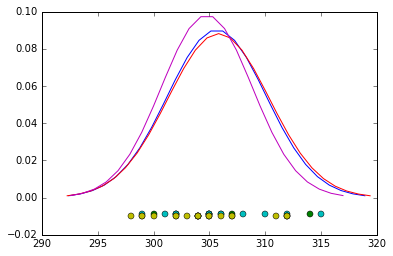

KstestResult(statistic=0.2154802435311064, pvalue=0.94332499623926225)
KstestResult(statistic=0.14958040662562122, pvalue=0.95112677836969006)
KstestResult(statistic=0.16921217445439685, pvalue=0.48057164801598251)


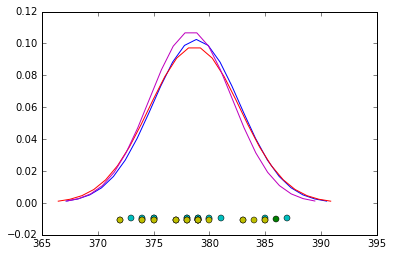

KstestResult(statistic=0.19403884992505971, pvalue=0.97759243899456794)
KstestResult(statistic=0.15030667384917618, pvalue=0.94916000909279497)
KstestResult(statistic=0.098760365363485814, pvalue=0.98658569105307392)


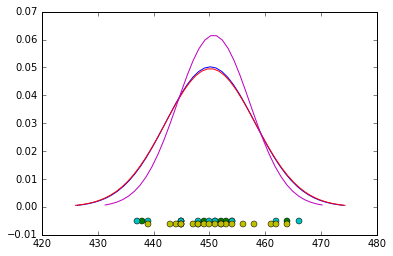

KstestResult(statistic=0.19357664838839272, pvalue=0.97811780608213816)
KstestResult(statistic=0.19155307715348269, pvalue=0.73692456895586256)
KstestResult(statistic=0.14711921679081807, pvalue=0.73441645662931743)


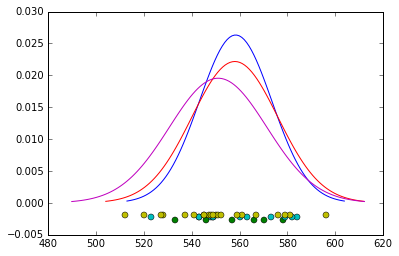

KstestResult(statistic=0.26145554093088519, pvalue=0.8066679530791977)
KstestResult(statistic=0.20811227385080711, pvalue=0.67870355925379089)
KstestResult(statistic=0.19585997047380183, pvalue=0.32513894713498237)


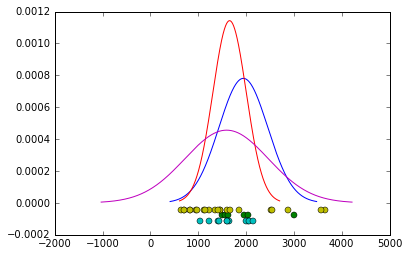

In [176]:
for p in [50, 90, 99, 99.9, 99.99]:
    dev_perc_1, dev_d_1 = read_and_plot(dev_dir_1, p, dev_perc_1, dev_d_1)
    dev_perc_2, dev_d_2 = read_and_plot(dev_dir_2, p, dev_perc_2, dev_d_2)
    dev_perc_4, dev_d_4 = read_and_plot(dev_dir_4, p, dev_perc_4, dev_d_4, threashold=0.9)
    plt.show()

### Same for Highlander

KstestResult(statistic=0.29876507994557189, pvalue=0.56986870930145361)
KstestResult(statistic=0.17467807940187624, pvalue=0.85745498774182161)
KstestResult(statistic=0.13287560560096862, pvalue=0.787952384923432)


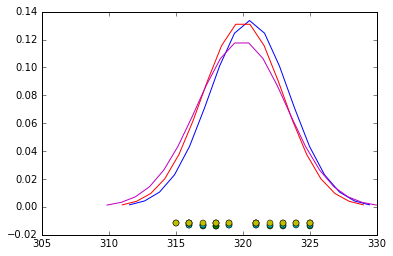

KstestResult(statistic=0.22789189008414035, pvalue=0.91432519050553562)
KstestResult(statistic=0.18491121994345538, pvalue=0.8064883628154903)
KstestResult(statistic=0.13887578070087137, pvalue=0.72570728317544031)


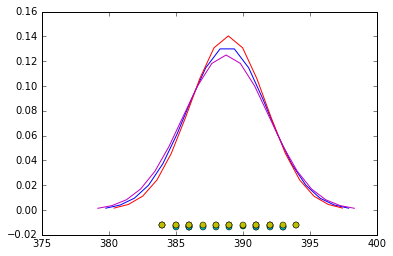

KstestResult(statistic=0.24750746245307709, pvalue=0.8558772672117031)
KstestResult(statistic=0.12620037141155993, pvalue=0.99098435518205175)
KstestResult(statistic=0.16944325556350498, pvalue=0.47876478440478976)


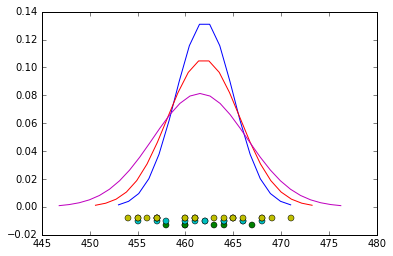

KstestResult(statistic=0.17659892506298119, pvalue=0.99206170539754379)
KstestResult(statistic=0.12792494442379165, pvalue=0.98942744804883032)
KstestResult(statistic=0.282598065354498, pvalue=0.047788098351290831)


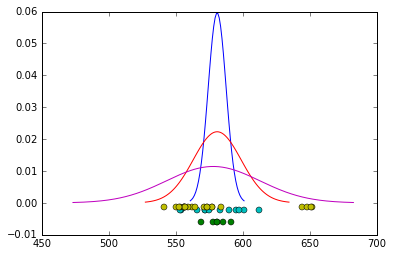

KstestResult(statistic=0.27489755484930384, pvalue=0.68681940193191315)
KstestResult(statistic=0.14552244928268676, pvalue=0.97397493654436551)
KstestResult(statistic=0.22816311082636204, pvalue=0.15566033554153691)


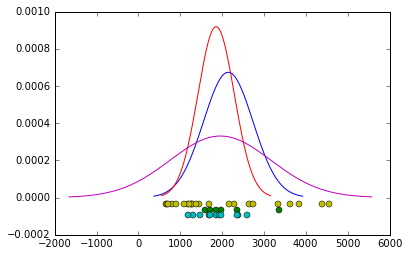

In [203]:
for p in [50, 90, 99, 99.9, 99.99]:
    high_perc_1, high_d_1 = read_and_plot(high_dir_1, p, high_perc_1, high_d_1)
    high_perc_2, high_d_2 = read_and_plot(high_dir_2, p, high_perc_2, high_d_2)
    high_perc_4, high_d_4 = read_and_plot(high_dir_4, p, high_perc_4, high_d_4, threashold=0.9)
    plt.show()

## Now Highlander vs Dev

#### Result value is crossection of distributions, the lower value means the difference between distributions is larger around this percentile.

In [198]:
cs = dict()
for k in dev_d_1:
    cs[k] = calc_crossection(dev_d_1[k], high_d_1[k])

KstestResult(statistic=0.21484563360983255, pvalue=0.94462749935119594)
KstestResult(statistic=0.29876507994557189, pvalue=0.56986870930145361)
Percentile: 50
CRITERIUM VALUE: 0.0221283699449


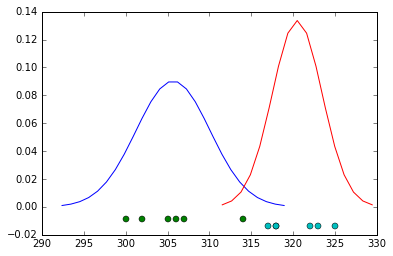

KstestResult(statistic=0.2154802435311064, pvalue=0.94332499623926225)
KstestResult(statistic=0.22789189008414035, pvalue=0.91432519050553562)
Percentile: 90
CRITERIUM VALUE: 0.0732806948421


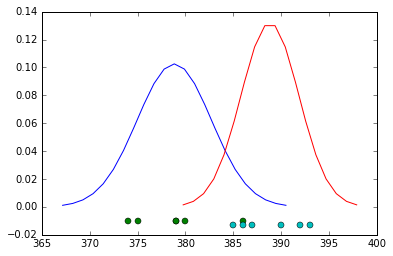

KstestResult(statistic=0.19403884992505971, pvalue=0.97759243899456794)
KstestResult(statistic=0.24750746245307709, pvalue=0.8558772672117031)
Percentile: 99
CRITERIUM VALUE: 0.121320193042


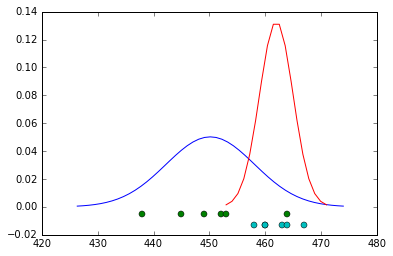

KstestResult(statistic=0.19357664838839272, pvalue=0.97811780608213816)
KstestResult(statistic=0.17659892506298119, pvalue=0.99206170539754379)
Percentile: 99.9
CRITERIUM VALUE: 0.136108071715


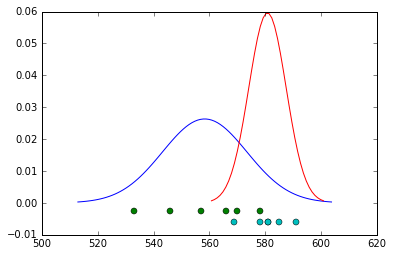

KstestResult(statistic=0.26145554093088519, pvalue=0.8066679530791977)
KstestResult(statistic=0.27489755484930384, pvalue=0.68681940193191315)
Percentile: 99.99
CRITERIUM VALUE: 0.421996054733


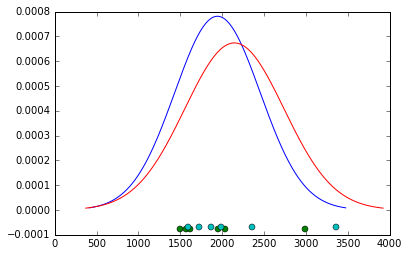

In [206]:
for p in [50, 90, 99, 99.9, 99.99]:
    read_and_plot(dev_dir_1, p, dict(), dict(), threashold=0.99)
    read_and_plot(high_dir_1, p, dict(), dict(), threashold=0.99)
    print "Percentile: {0}".format(p)
    print "CRITERIUM VALUE: {0}".format(cs[p])
    plt.show()